In [ ]:
import numpy as np
import lammps
from lammps import LMP_STYLE_ATOM, LMP_TYPE_ARRAY
import matplotlib.pyplot as plt


# This a wrapper function and should be used with caution:
# Periodic datasets with  lammps-format style atomic is currently supported
# Wishlist:- a fitSNAP and LAMMPS-provided descriptor extraction function 

def compute_bispectrum(lmp_struc, cutfac, rfrac0, twojmax, R, w):
    '''
    Hyper-parmaters:

    cutfac = scale factor applied to all cutoff radii (positive real) : float

    rfac0 = parameter in distance to angle conversion (0 < rcutfac < 1) : float

    twojmax = band limit for bispectrum components (non-negative integer) : int

    R_1, R_2,… = list of cutoff radii, one for each type (distance units) : list

    w_1, w_2,… = list of neighbor weights, one for each type : list
    
    Returns
    --------
    BiSpec: Bispectrum components for each atoms
    '''

    lmp = lammps.lammps(cmdargs=['-sc','.lammps_output.txt', '-l', 'None'])
    
    R_max = max(R)
    R = ' '.join(map(str, R))
    w = ' '.join(map(str, w))
    
    
    doctring = f"""
    #LAMMPS input file
    # ------------------------ INITIALIZATION ----------------------------
    processors    * * *
    units         metal
    dimension    3
    boundary    p    p    p
    atom_style   atomic
    box tilt large
    #--------------------------- LAMMPS Data File -------------------------
    read_data     {lmp_struc}
    mass * 1.0
    #--------------------------- DUMMY FORCE_FIELD -------------------------
    pair_style      zero {cutfac*R_max*2}
    pair_coeff      * *  
    
    """
    try:
        lmp.commands_string(doctring)
    except Exception as e:
        raise RuntimeError(f'LAMMPS: {e}\n')

    #-------- Compute SNAP descriptors ---------------------        
    lmp.command(f'compute BiSpec all sna/atom {cutfac} {rfrac0} {twojmax} {R} {w} chem 2 0 1 ')
    
    try:
        lmp.command('run 0')
    except Exception as e:
        raise RuntimeError(f'LAMMPS: {e}\n')

	#-------- Extract SNAP descriptors ---------------------
    Natoms = lmp.get_natoms()
    print ((f'Number of atoms in the system: {Natoms}'))
    
    if twojmax==8:
        snap_shape = (Natoms, 55)
    elif twojmax==6:
        snap_shape = (Natoms, 30)
    else:
        ValueError(f'Unsupported twojmax value: {twojmax}. Supported values are 6 or 8.')
    # data = lmp.extract_compute('BiSpec', LMP_STYLE_ATOM, LMP_TYPE_ARRAY)    
    # ptr = ctypes.cast(data, ctypes.POINTER(ctypes.c_double))
    # BiSpec = np.ctypeslib.as_array(ptr, shape=snap_shape)
    BiSpec = lmp.numpy.extract_compute('BiSpec', LMP_STYLE_ATOM, LMP_TYPE_ARRAY).copy()
          
    
    t = lmp.gather_atoms('type',0,1)
    types = np.ctypeslib.as_array(t)
    
    lmp.close()
    
    return BiSpec, types


def compute_decriptor_PCA(data, num_PC=3):
	"""
	Reduces descriptor dimensions by first standardizing the data and then applying PCA.
	
	Returns
	-------
	x: Principal components
	variances: Explained variance ratio of the principal components.
	"""
	from sklearn.decomposition import PCA
	from sklearn.preprocessing import StandardScaler
	# scaling = StandardScaler()
	# scaling.fit(data)
	# Scaled_data = scaling.transform(data)
	Scaled_data = data
	principal = PCA(n_components=num_PC)
	principal.fit(Scaled_data)
	x = principal.transform(Scaled_data)
	variances = principal.explained_variance_ratio_
	return x, variances

In [2]:

files = ['WSe_Structures/2X_1T_uc.lmp', 'WSe_Structures/1600000_2X_1T_1500K_scale.lmp', 'WSe_Structures/2X_2H_uc.lmp', 'WSe_Structures/1600000_2X_1T_1500K_scale1.0476.lmp', 'WSe_Structures/1600000_2X_2H_1500K_scale1.0476.lmp', 'WSe_Structures/1600000_2X_2H_1500K_scale1.lmp']

descrptors = {'structure': ['1T', 'recryst_1T_1500K', '2H', 'recryst_2T_1500K_Strain', 'recryst_2H_1500K_Strain', 'recryst_2H_1500K'], 'Values': [], 'PCA': []}

for ic, file in enumerate(files):
	bispec_descr, lmp_types = compute_bispectrum(lmp_struc=file, cutfac=1, rfrac0=0.5, twojmax=8, R=[2,2], w=[2,1])
	bispec_descr_metals = bispec_descr[lmp_types==1]
	descrptors['Values'].append(bispec_descr_metals)
	bispec_descr_metals_pca = compute_decriptor_PCA(bispec_descr_metals, num_PC=50)
	descrptors['PCA'].append(bispec_descr_metals_pca[0])
	# plt.hist(descrptors['Values'][ic].mean(axis=0), bins=1000, label=descrptors['structure'][ic], alpha=0.5)

Number of atoms in the system: 216
Number of atoms in the system: 432
Number of atoms in the system: 216
Number of atoms in the system: 432
Number of atoms in the system: 432
Number of atoms in the system: 432


In [3]:
from sklearn.metrics.pairwise import cosine_similarity

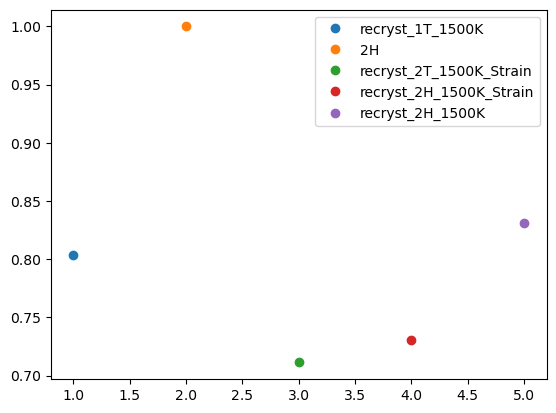

In [ ]:
for ic in range(1,6):
	sim = cosine_similarity(np.abs(descrptors['PCA'][0]).mean(axis=0).reshape(1, -1), np.abs(descrptors['PCA'][ic]).mean(axis=0).reshape(1, -1))
	plt.plot(ic, sim, 'o', label=descrptors['structure'][ic])
plt.legend()

In [5]:
cosine_similarity(np.abs(descrptors['PCA'][0]).mean(axis=0).reshape(1, -1), np.abs(descrptors['PCA'][2]).mean(axis=0).reshape(1, -1))

array([[0.99999999]])

In [ ]:
plt.plot(ic, sim, label=descrptors['structure'][ic], alpha=0.5)

In [ ]:
ic, sim